In [ ]:
!git clone https://github.com/Daisuke0713/ANN-final.git
%cd ./ANN-final/DDPMs

In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
from PIL import Image

import tensorflow as tf
from tensorflow import keras, einsum
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Layer
import tensorflow.keras.layers as nn
import tensorflow_addons as tfa
import tensorflow_datasets as tfds

from einops import rearrange
from einops.layers.tensorflow import Rearrange
from functools import partial
from inspect import isfunction

# Suppressing tf.hub warnings
tf.get_logger().setLevel("ERROR")

# configure the GPU
# gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8)
# config = tf.compat.v1.ConfigProto(gpu_options=gpu_options)
# session = tf.compat.v1.Session(config=config)

In [ ]:
gpu_device = tf.test.gpu_device_name()
cpu_device = '/cpu:0'
# set CPU the device for now
device = gpu_device

In [17]:
# set the parameters for dataset
target_size = (32, 32)
channels = 1
BATCH_SIZE=64

# Normalization helper
def preprocess(x, y):
    with tf.device(device):
        return tf.image.resize(tf.cast(x, tf.float32) / 127.5 - 1, (32, 32))

def get_datasets():
    with tf.device(device):
        # Load the MNIST dataset
        train_ds = tfds.load('mnist', as_supervised=True, split="train")

        # Normalize to [-1, 1], shuffle and batch
        train_ds = train_ds.map(preprocess, tf.data.AUTOTUNE)
        train_ds = train_ds.shuffle(5000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

        # Return numpy arrays instead of TF tensors while iterating
        return tfds.as_numpy(train_ds)


dataset = get_datasets()

In [18]:
timesteps = 200

# create a fixed beta schedule
beta = np.linspace(0.0001, 0.02, timesteps)

# this will be used as discussed in the reparameterization trick
alpha = 1 - beta
alpha_bar = np.cumprod(alpha, 0)
alpha_bar = np.concatenate((np.array([1.]), alpha_bar[:-1]), axis=0)
sqrt_alpha_bar = np.sqrt(alpha_bar)
one_minus_sqrt_alpha_bar = np.sqrt(1-alpha_bar)

# this function will help us set the RNG key for Numpy
def set_key(key):
    with tf.device(device):
        np.random.seed(key)

# this function will add noise to the input as per the given timestamp
def forward_noise(key, x_0, t):
    with tf.device(device):
        set_key(key)
        noise = np.random.normal(size=x_0.shape)
        reshaped_sqrt_alpha_bar_t = np.reshape(np.take(sqrt_alpha_bar, t), (-1, 1, 1, 1))
        reshaped_one_minus_sqrt_alpha_bar_t = np.reshape(np.take(one_minus_sqrt_alpha_bar, t), (-1, 1, 1, 1))
        noisy_image = reshaped_sqrt_alpha_bar_t  * x_0 + reshaped_one_minus_sqrt_alpha_bar_t  * noise
        return noisy_image, noise

# this function will be used to create sample timestamps between 0 & T
def generate_timestamp(key, num):
    with tf.device(device):
        set_key(key)
        return tf.random.uniform(shape=[num], minval=0, maxval=timesteps, dtype=tf.int32)

2023-04-24 12:53:45.427077: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


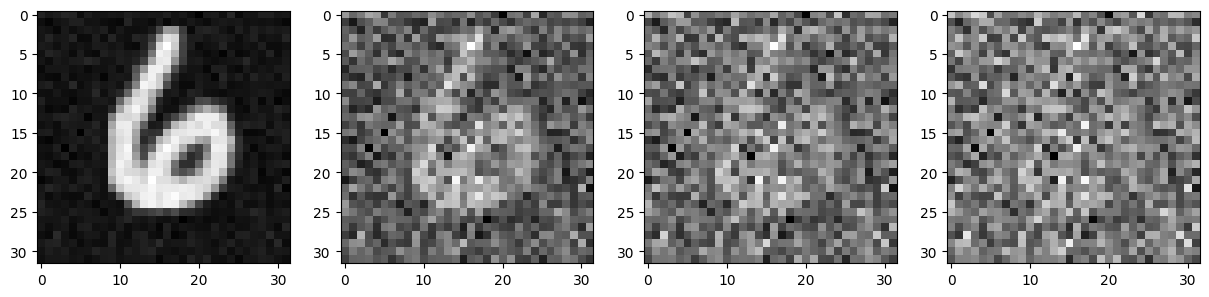

In [19]:
# Let us visualize the output image at a few timestamps
sample_mnist = next(iter(dataset))[0]

fig = plt.figure(figsize=(15, 30))

for index, i in enumerate([10, 100, 150, 199]):
    noisy_im, noise = forward_noise(0, np.expand_dims(sample_mnist, 0), np.array([i,]))
    plt.subplot(1, 4, index+1)
    plt.imshow(np.squeeze(np.squeeze(noisy_im, -1), 0), cmap='gray')
    

plt.show()

In [20]:
# helpers functions
def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

# We will use this to convert timestamps to time encodings
class SinusoidalPosEmb(Layer):
    def __init__(self, dim, max_positions=10000):
        super(SinusoidalPosEmb, self).__init__()
        self.dim = dim
        self.max_positions = max_positions

    def call(self, x, training=True):
        with tf.device(device):
            x = tf.cast(x, tf.float32)
            half_dim = self.dim // 2
            emb = math.log(self.max_positions) / (half_dim - 1)
            emb = tf.exp(tf.range(half_dim, dtype=tf.float32) * -emb)
            emb = x[:, None] * emb[None, :]

            emb = tf.concat([tf.sin(emb), tf.cos(emb)], axis=-1)

            return emb
        
# small helper modules
class Identity(Layer):
    def __init__(self):
        super(Identity, self).__init__()

    def call(self, x, training=True):
        with tf.device(device):
            return tf.identity(x)


class Residual(Layer):
    def __init__(self, fn):
        super(Residual, self).__init__()
        self.fn = fn

    def call(self, x, training=True):
        with tf.device(device):
            return self.fn(x, training=training) + x

def Upsample(dim):
    return nn.Conv2DTranspose(filters=dim, kernel_size=4, strides=2, padding='SAME')

def Downsample(dim):
    return nn.Conv2D(filters=dim, kernel_size=4, strides=2, padding='SAME')

class LayerNorm(Layer):
    def __init__(self, dim, eps=1e-5, **kwargs):
        super(LayerNorm, self).__init__(**kwargs)
        self.eps = eps

        self.g = tf.Variable(tf.ones([1, 1, 1, dim]))
        self.b = tf.Variable(tf.zeros([1, 1, 1, dim]))

    def call(self, x, training=True):
        with tf.device(device):
            var = tf.math.reduce_variance(x, axis=-1, keepdims=True)
            mean = tf.reduce_mean(x, axis=-1, keepdims=True)

            x = (x - mean) / tf.sqrt((var + self.eps)) * self.g + self.b
            return x

class PreNorm(Layer):
    def __init__(self, dim, fn):
        super(PreNorm, self).__init__()
        self.fn = fn
        self.norm = LayerNorm(dim)

    def call(self, x, training=True):
        with tf.device(device):
            x = self.norm(x)
            return self.fn(x)

class SiLU(Layer):
    def __init__(self):
        super(SiLU, self).__init__()

    def call(self, x, training=True):
        with tf.device(device):
            return x * tf.nn.sigmoid(x)

def gelu(x, approximate=False):
    with tf.device(device):
        if approximate:
            coeff = tf.cast(0.044715, x.dtype)
            return 0.5 * x * (1.0 + tf.tanh(0.7978845608028654 * (x + coeff * tf.pow(x, 3))))
        else:
            return 0.5 * x * (1.0 + tf.math.erf(x / tf.cast(1.4142135623730951, x.dtype)))

class GELU(Layer):
    def __init__(self, approximate=False):
        super(GELU, self).__init__()
        self.approximate = approximate

    def call(self, x, training=True):
        with tf.device(device):
            return gelu(x, self.approximate)

In [21]:
# building block modules
class Block(Layer):
    def __init__(self, dim, groups=8):
        super(Block, self).__init__()
        self.proj = nn.Conv2D(dim, kernel_size=3, strides=1, padding='SAME')
        self.norm = tfa.layers.GroupNormalization(groups, epsilon=1e-05)
        self.act = SiLU()


    def call(self, x, gamma_beta=None, training=True):
        with tf.device(device):
            x = self.proj(x)
            x = self.norm(x, training=training)

            if exists(gamma_beta):
                gamma, beta = gamma_beta
                x = x * (gamma + 1) + beta

            x = self.act(x)
            return x

class ResnetBlock(Layer):
    def __init__(self, dim, dim_out, time_emb_dim=None, groups=8):
        super(ResnetBlock, self).__init__()

        self.mlp = Sequential([
            SiLU(),
            nn.Dense(units=dim_out * 2)
        ]) if exists(time_emb_dim) else None

        self.block1 = Block(dim_out, groups=groups)
        self.block2 = Block(dim_out, groups=groups)
        self.res_conv = nn.Conv2D(filters=dim_out, kernel_size=1, strides=1) if dim != dim_out else Identity()

    def call(self, x, time_emb=None, training=True):
        with tf.device(device):
            gamma_beta = None
            if exists(self.mlp) and exists(time_emb):
                time_emb = self.mlp(time_emb)
                time_emb = rearrange(time_emb, 'b c -> b 1 1 c')
                gamma_beta = tf.split(time_emb, num_or_size_splits=2, axis=-1)

            h = self.block1(x, gamma_beta=gamma_beta, training=training)
            h = self.block2(h, training=training)

            return h + self.res_conv(x)

class LinearAttention(Layer):
    def __init__(self, dim, heads=4, dim_head=32):
        super(LinearAttention, self).__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        self.hidden_dim = dim_head * heads

        self.attend = nn.Softmax()
        self.to_qkv = nn.Conv2D(filters=self.hidden_dim * 3, kernel_size=1, strides=1, use_bias=False)

        self.to_out = Sequential([
            nn.Conv2D(filters=dim, kernel_size=1, strides=1),
            LayerNorm(dim)
        ])

    def call(self, x, training=True):
        with tf.device(device):
            b, h, w, c = x.shape
            qkv = self.to_qkv(x)
            qkv = tf.split(qkv, num_or_size_splits=3, axis=-1)
            q, k, v = map(lambda t: rearrange(t, 'b x y (h c) -> b h c (x y)', h=self.heads), qkv)

            q = tf.nn.softmax(q, axis=-2)
            k = tf.nn.softmax(k, axis=-1)

            q = q * self.scale
            context = einsum('b h d n, b h e n -> b h d e', k, v)

            out = einsum('b h d e, b h d n -> b h e n', context, q)
            out = rearrange(out, 'b h c (x y) -> b x y (h c)', h=self.heads, x=h, y=w)
            out = self.to_out(out, training=training)

            return out

class Attention(Layer):
    def __init__(self, dim, heads=4, dim_head=32):
        super(Attention, self).__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        self.hidden_dim = dim_head * heads

        self.to_qkv = nn.Conv2D(filters=self.hidden_dim * 3, kernel_size=1, strides=1, use_bias=False)
        self.to_out = nn.Conv2D(filters=dim, kernel_size=1, strides=1)

    def call(self, x, training=True):
        with tf.device(device):
            b, h, w, c = x.shape
            qkv = self.to_qkv(x)
            qkv = tf.split(qkv, num_or_size_splits=3, axis=-1)
            q, k, v = map(lambda t: rearrange(t, 'b x y (h c) -> b h c (x y)', h=self.heads), qkv)
            q = q * self.scale

            sim = einsum('b h d i, b h d j -> b h i j', q, k)
            sim_max = tf.stop_gradient(tf.expand_dims(tf.argmax(sim, axis=-1), axis=-1))
            sim_max = tf.cast(sim_max, tf.float32)
            sim = sim - sim_max
            attn = tf.nn.softmax(sim, axis=-1)

            out = einsum('b h i j, b h d j -> b h i d', attn, v)
            out = rearrange(out, 'b h (x y) d -> b x y (h d)', x = h, y = w)
            out = self.to_out(out, training=training)

            return out

In [22]:
class Unet(Model):
    def __init__(self,
                 dim=64,
                 init_dim=None,
                 out_dim=None,
                 dim_mults=(1, 2, 4, 8),
                 channels=3,
                 resnet_block_groups=8,
                 learned_variance=False,
                 sinusoidal_cond_mlp=True
                 ):
        super(Unet, self).__init__()
        
        # determine dimensions
        self.channels = channels
        
        init_dim = default(init_dim, dim // 3 * 2)
        self.init_conv = nn.Conv2D(filters=init_dim, kernel_size=7, strides=1, padding='SAME')
        
        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))
        
        block_klass = partial(ResnetBlock, groups = resnet_block_groups)
        
        # time embeddings
        time_dim = dim * 4
        self.sinusoidal_cond_mlp = sinusoidal_cond_mlp
        
        self.time_mlp = Sequential([
            SinusoidalPosEmb(dim),
            nn.Dense(units=time_dim),
            GELU(),
            nn.Dense(units=time_dim)
        ], name="time embeddings")
        
        # layers
        self.downs = []
        self.ups = []
        num_resolutions = len(in_out)
        
        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append([
                block_klass(dim_in, dim_out, time_emb_dim=time_dim),
                block_klass(dim_out, dim_out, time_emb_dim=time_dim),
                Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                Downsample(dim_out) if not is_last else Identity()
            ])
  
        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        
        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (num_resolutions - 1)

            self.ups.append([
                block_klass(dim_out * 2, dim_in, time_emb_dim=time_dim),
                block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                Upsample(dim_in) if not is_last else Identity()
            ])
        
        default_out_dim = channels * (1 if not learned_variance else 2)
        self.out_dim = default(out_dim, default_out_dim)
        
        self.final_conv = Sequential([
            block_klass(dim * 2, dim),
            nn.Conv2D(filters=self.out_dim, kernel_size=1, strides=1)
        ], name="output")
        
    def call(self, x, time=None, training=True, **kwargs):
        x = self.init_conv(x)
        t = self.time_mlp(time)
        
        h = []

        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            h.append(x)
            x = downsample(x)

        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        for block1, block2, attn, upsample in self.ups:
            x = tf.concat([x, h.pop()], axis=-1)
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            x = upsample(x)

        x = tf.concat([x, h.pop()], axis=-1)
        x = self.final_conv(x)
        return x

In [23]:
# create our unet model
unet = Unet(channels=1)

# create our checkopint manager
ckpt = tf.train.Checkpoint(unet=unet)
ckpt_manager = tf.train.CheckpointManager(ckpt, "./checkpoints", max_to_keep=2)

# load from a previous checkpoint if it exists, else initialize the model from scratch
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    start_interation = int(ckpt_manager.latest_checkpoint.split("-")[-1])
    print("Restored from {}".format(ckpt_manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

# initialize the model in the memory of our GPU
test_images = np.ones([1, 32, 32, 1])
test_timestamps = generate_timestamp(0, 1)
k = unet(test_images, test_timestamps)

# create our optimizer, we will use adam with a Learning rate of 1e-4
opt = keras.optimizers.Adam(learning_rate=1e-4)

Restored from ./checkpoints/ckpt-9


In [9]:
def loss_fn(real, generated):
    loss = tf.math.reduce_mean((real - generated) ** 2)
    return loss

In [10]:
rng = 0

def train_step(batch):
    with tf.device(device):
        rng, tsrng = np.random.randint(0, 100000, size=(2,))
        timestep_values = generate_timestamp(tsrng, batch.shape[0])

        noised_image, noise = forward_noise(rng, batch, timestep_values)
        with tf.GradientTape() as tape:
            prediction = unet(noised_image, timestep_values)
            
            loss_value = loss_fn(noise, prediction)
        
        gradients = tape.gradient(loss_value, unet.trainable_variables)
        opt.apply_gradients(zip(gradients, unet.trainable_variables))

        return loss_value

In [11]:
def train():
    with tf.device(device):
        epochs = 10
        for e in range(1, epochs+1):
            # this is cool utility in Tensorflow that will create a nice looking progress bar
            bar = tf.keras.utils.Progbar(len(dataset)-1)
            losses = []
            for i, batch in enumerate(iter(dataset)):
                # run the training loop
                loss = train_step(batch)
                losses.append(loss)
                bar.update(i, values=[("loss", loss)])

            avg = np.mean(losses)
            print(f"Average loss for epoch {e}/{epochs}: {avg}")
            ckpt_manager.save(checkpoint_number=e)

In [24]:
# Save a GIF using logged images
def save_gif(img_list, path="", interval=200):
    # Transform images from [-1,1] to [0, 255]
    imgs = []
    for im in img_list:
        im = np.array(im)
        im = (im + 1) * 127.5
        im = np.clip(im, 0, 255).astype(np.int32)
        im = Image.fromarray(im)
        imgs.append(im)
    
    imgs = iter(imgs)

    # Extract first image from iterator
    img = next(imgs)

    # Append the other images and save as GIF
    img.save(fp=path, format='GIF', append_images=imgs,
             save_all=True, duration=interval, loop=0)

In [25]:
def ddpm(x_t, pred_noise, t):
    with tf.device(device):
        alpha_t = np.take(alpha, t)
        alpha_t_bar = np.take(alpha_bar, t)

        eps_coef = (1 - alpha_t) / (1 - alpha_t_bar) ** .5
        mean = (1 / (alpha_t ** .5)) * (x_t - eps_coef * pred_noise)

        var = np.take(beta, t)
        z = np.random.normal(size=x_t.shape)

        return mean + (var ** .5) * z

In [ ]:
with tf.device(device):
    x = tf.random.normal((1,32,32,1))
    img_list = []
    img_list.append(np.squeeze(np.squeeze(x, 0),-1))

    for i in tqdm(range(timesteps-1)):
        t = np.expand_dims(np.array(timesteps-i-1, np.int32), 0)
        pred_noise = unet(x, t)
        x = ddpm(x, pred_noise, t)
        img_list.append(np.squeeze(np.squeeze(x, 0),-1))

        if i % 25==0:
            plt.imshow(np.array(np.clip((x[0] + 1) * 127.5, 0, 255), np.uint8), cmap="gray")
            plt.show()

# save_gif(img_list + ([img_list[-1]] * 100), "ddpm.gif", interval=20)

# plt.imshow(np.array(np.clip((x[0] + 1) * 127.5, 0, 255), np.uint8))
# plt.show()